<a href="https://colab.research.google.com/github/MikeNsiah10/DLTFpT/blob/master/iannwtf_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import the necessary libraries

In [56]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers,models

#Load the data

In [57]:
#load the datasets
(train_set,test_set),set_info=tfds.load('cifar10', split=['train','test'],as_supervised=True,with_info=True)
#print(set_info)


In [58]:
#print the label and image shape
for image, label in train_set.take(1):
    min_pixel_value = tf.reduce_min(image)
    max_pixel_value = tf.reduce_max(image)
    print("Pixel Value Range: [{}, {}]".format(min_pixel_value.numpy(), max_pixel_value.numpy()))

    print("Label:", label)
    print("Image Shape:", image.shape)


Pixel Value Range: [0, 249]
Label: tf.Tensor(7, shape=(), dtype=int64)
Image Shape: (32, 32, 3)


In [59]:
#print training and testing sets
train_images= set_info.splits['train'].num_examples
test_images= set_info.splits['test'].num_examples
print(f'training images:{train_images}, testing images:{test_images}')


training images:50000, testing images:10000


#Visualise the data

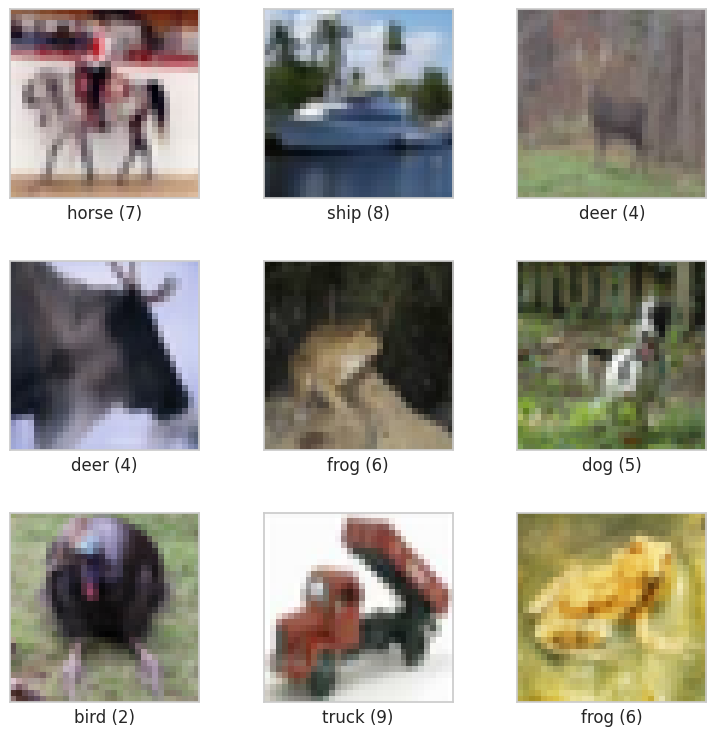

In [60]:
figure = tfds.show_examples(train_set, set_info)

#Preprocess the data

In [61]:
def pre_process(cifar_images):
  #convert the dtype to float32
  cifar_images=cifar_images.map(lambda img,target:(tf.cast(img,tf.float32),target))
  #normalize the images between the values [-1,1]
  cifar_images=cifar_images.map(lambda img,target:((img/128)-1.,target))
  #Ensure target values are cast to integer type
  cifar_images = cifar_images.map(lambda img, target: (img, tf.cast(target, tf.int64)))
  #one-hot encode the labels
  cifar_images=cifar_images.map(lambda img,target:(img,tf.one_hot(target,depth=10)))
  #return preprocessed data
  return cifar_images

train_set=train_set.apply(pre_process)
test_set=test_set.apply(pre_process)

#CNN Model Architecture


In [90]:
class CNNModel(tf.keras.Model):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Define layers
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')


        self.global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        # Forward pass
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.global_avg_pooling(x)
        x = self.dense(x)
        return x


#Training Loop

In [91]:
# Instantiate the metric objects
# Instantiate the model
ConvModel = CNNModel()

train_data = train_set.take(1000)
test_data = test_set.take(1000)

# Define hyperparameters
learning_rate = 0.01
num_epochs = 15
batch_size = 32
loss_func = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate )


train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
train_accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
test_loss_metric = tf.keras.metrics.Mean(name='test_loss')
test_accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

def train(train_data, test_data, num_epochs, loss_func, optimizer, batch_size, ConvModel,
          train_loss_metric, train_accuracy_metric, test_loss_metric, test_accuracy_metric):
    train_losses=[]
    train_accuracies=[]
    test_losses=[]
    test_accuracies=[]

    for epoch in range(num_epochs):
        for image, label in train_data.batch(batch_size):
            with tf.GradientTape() as tape:
                prediction = ConvModel(image,training=True)
                # Compute the loss
                loss = loss_func(label, prediction)

            # Backpropagate and optimize
            gradients = tape.gradient(loss, ConvModel.trainable_variables)
            optimizer.apply_gradients(zip(gradients, ConvModel.trainable_variables))

            # Update training metrics
            train_loss_metric.update_state(loss)
            train_accuracy_metric.update_state(label, prediction)

        # Calculate training metrics at the end of each epoch
        train_loss = train_loss_metric.result()
        train_accuracy = train_accuracy_metric.result()

        # Reset the training metrics for the next epoch
        train_loss_metric.reset_states()
        train_accuracy_metric.reset_states()

        # Loop through the validation set
        for image, label in test_data.batch(batch_size):
            prediction = ConvModel(image)
            test_loss = loss_func(label, prediction)

            # Update validation metrics
            test_loss_metric.update_state(test_loss)
            test_accuracy_metric.update_state(label, prediction)

        # Calculate validation metrics at the end of each epoch
        test_loss = test_loss_metric.result()
        test_accuracy = test_accuracy_metric.result()

        # Reset the validation metrics for the next epoch
        test_loss_metric.reset_states()
        test_accuracy_metric.reset_states()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch}, "
              f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, "
              f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    return train_losses, train_accuracies, test_losses, test_accuracies

# Call the training function
train_losses, train_accuracies, test_losses, test_accuracies = train(
    train_data, test_data, num_epochs, loss_func, optimizer, batch_size, ConvModel,
    train_loss_metric, train_accuracy_metric, test_loss_metric, test_accuracy_metric
)


Epoch 0, Train Loss: 2.2045466899871826, Train Accuracy: 0.16599999368190765, Test Loss: 2.2261152267456055, Test Accuracy: 0.19200000166893005
Epoch 1, Train Loss: 2.094475269317627, Train Accuracy: 0.21400000154972076, Test Loss: 2.0619051456451416, Test Accuracy: 0.20499999821186066
Epoch 2, Train Loss: 2.0197103023529053, Train Accuracy: 0.20999999344348907, Test Loss: 1.9744510650634766, Test Accuracy: 0.2619999945163727
Epoch 3, Train Loss: 1.951529622077942, Train Accuracy: 0.22599999606609344, Test Loss: 1.9559292793273926, Test Accuracy: 0.25699999928474426
Epoch 4, Train Loss: 1.9022469520568848, Train Accuracy: 0.24500000476837158, Test Loss: 1.9436242580413818, Test Accuracy: 0.2720000147819519
Epoch 5, Train Loss: 1.8532812595367432, Train Accuracy: 0.27300000190734863, Test Loss: 1.887188196182251, Test Accuracy: 0.29499998688697815
Epoch 6, Train Loss: 1.8200842142105103, Train Accuracy: 0.29600000381469727, Test Loss: 1.8492882251739502, Test Accuracy: 0.294999986886978

In [1]:
import matplotlib.pyplot as plt
plt . figure ()
line1 , = plt. plot ( train_losses , "b-")
line2 , = plt. plot ( test_losses , "r-")
line3 , = plt. plot ( train_accuracies , "b:")
line4 , = plt. plot ( test_accuracies , "r:")
plt.title('Training and Loss metrics')
plt . xlabel (" Epochs ")
plt . ylabel (" Loss / Accuracy ")
plt . legend (( line1 , line2 , line3 , line4 ), (" training loss ", "test loss ", " train accuracy ", " test accuracy "))
plt . show ()


NameError: ignored

<Figure size 640x480 with 0 Axes>

#Adjusting the hyperparameters and architecture

In [22]:
class CNNModel(tf.keras.Model):
    def __init__(self, architecture):
        super(CNNModel, self).__init__()

        # Define layers based on the specified architecture
        self.conv1 = tf.keras.layers.Conv2D(architecture[0], (3, 3), activation='relu', padding='same')
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(architecture[1], (3, 3), activation='relu', padding='same')
        self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))

        self.global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        # Forward pass
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.global_avg_pooling(x)
        x = self.flatten(x)
        x = self.dense1(x)
        output = self.dense2(x)
        return output


import matplotlib.pyplot as plt

# Define hyperparameter and architecture settings
learning_rates = [0.001, 0.01]
architectures = [(32, 64), (64, 128)]  # Modify based on your needs
optimizers_list = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]  # You can choose other optimizers as well

# Initialize lists to store results
results = []

# Loop through each combination of hyperparameters and architectures
for lr in learning_rates:
    for arch in architectures:
        for opt in optimizers_list:
            # Create the model
            ConvModel = CNNModel(arch)

            # Define hyperparameters
            optimizer = opt(lr)
            train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
            train_accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
            test_loss_metric = tf.keras.metrics.Mean(name='test_loss')
            test_accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

            # Call the training function
            train_losses, train_accuracies, test_losses, test_accuracies = train(
                train_data, test_data, num_epochs, loss_func, optimizer, batch_size, ConvModel,
                train_loss_metric, train_accuracy_metric, test_loss_metric, test_accuracy_metric
            )

            # Store results
            results.append({
                'learning_rate': lr,
                'architecture': arch,
                'optimizer': opt.__name__,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies
            })





Epoch 1, Train Loss: 2.280339002609253, Train Accuracy: 0.1469999998807907, Test Loss: 2.247673511505127, Test Accuracy: 0.1599999964237213
Epoch 2, Train Loss: 2.1758038997650146, Train Accuracy: 0.21199999749660492, Test Loss: 2.153693914413452, Test Accuracy: 0.17499999701976776
Epoch 3, Train Loss: 2.0846266746520996, Train Accuracy: 0.20499999821186066, Test Loss: 2.0916318893432617, Test Accuracy: 0.2199999988079071
Epoch 4, Train Loss: 2.0333757400512695, Train Accuracy: 0.2070000022649765, Test Loss: 2.05399751663208, Test Accuracy: 0.22599999606609344
Epoch 5, Train Loss: 1.9991378784179688, Train Accuracy: 0.23000000417232513, Test Loss: 2.017883777618408, Test Accuracy: 0.24500000476837158
Epoch 6, Train Loss: 1.964316964149475, Train Accuracy: 0.24899999797344208, Test Loss: 1.9881954193115234, Test Accuracy: 0.25999999046325684
Epoch 7, Train Loss: 1.9332234859466553, Train Accuracy: 0.2669999897480011, Test Loss: 1.9638984203338623, Test Accuracy: 0.2669999897480011
Epoch

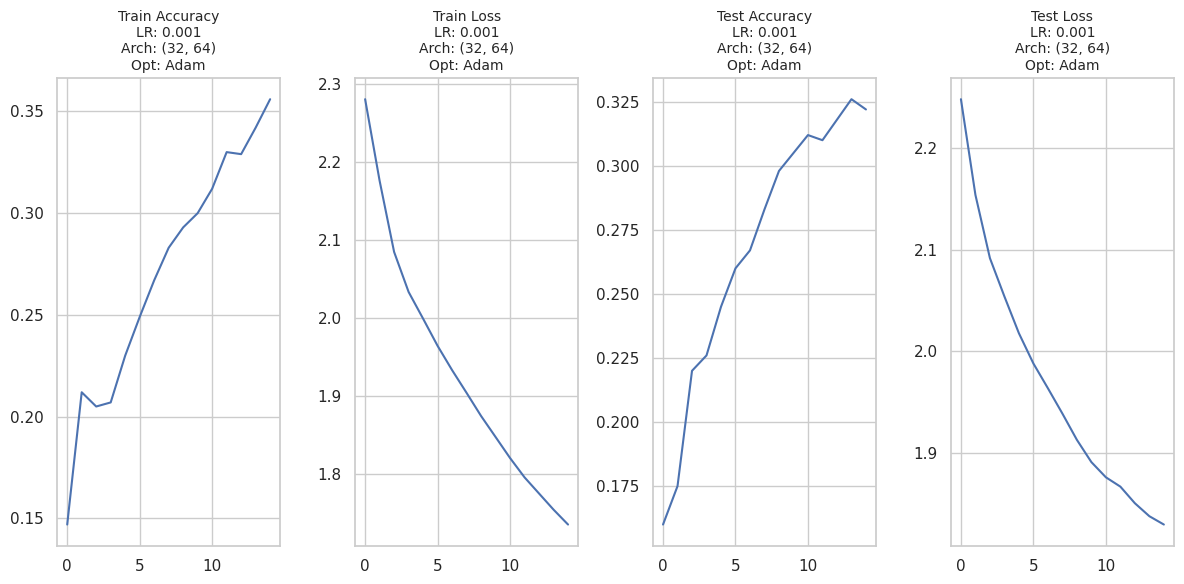

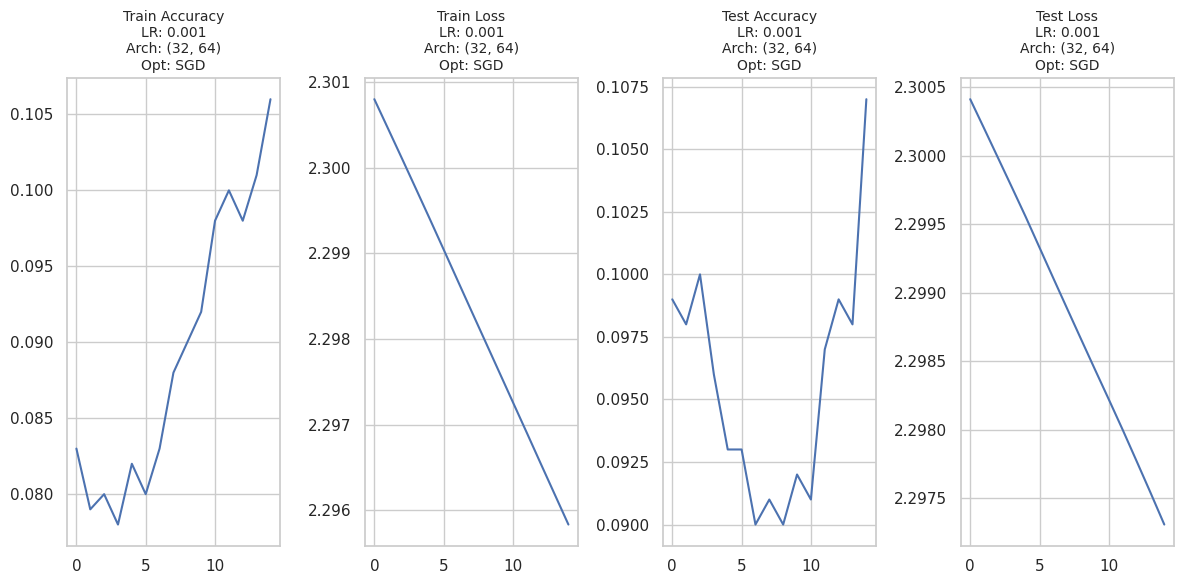

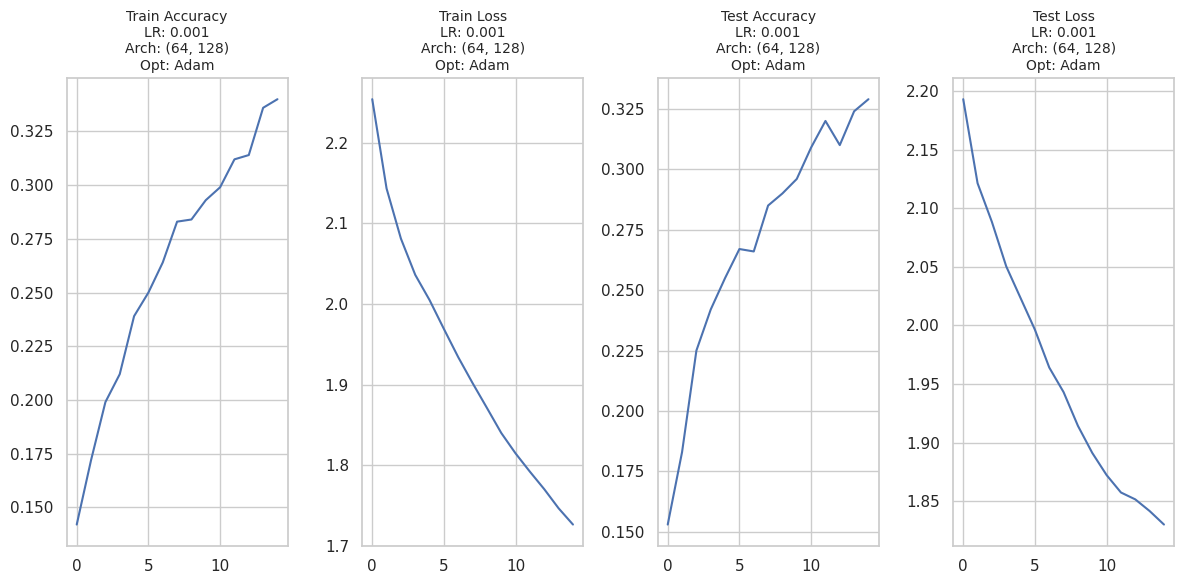

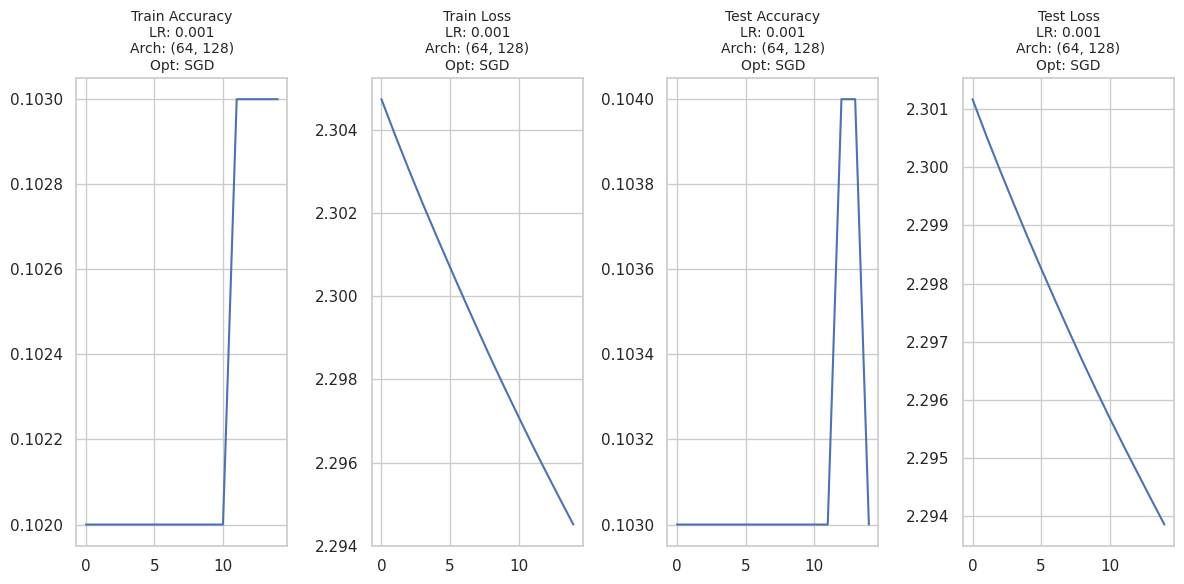

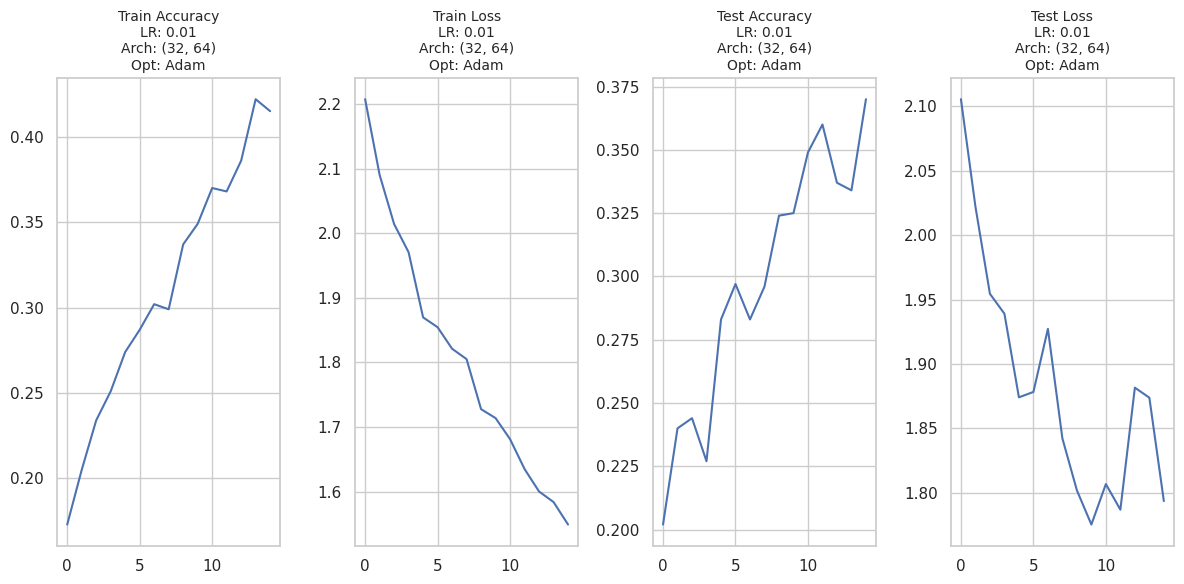

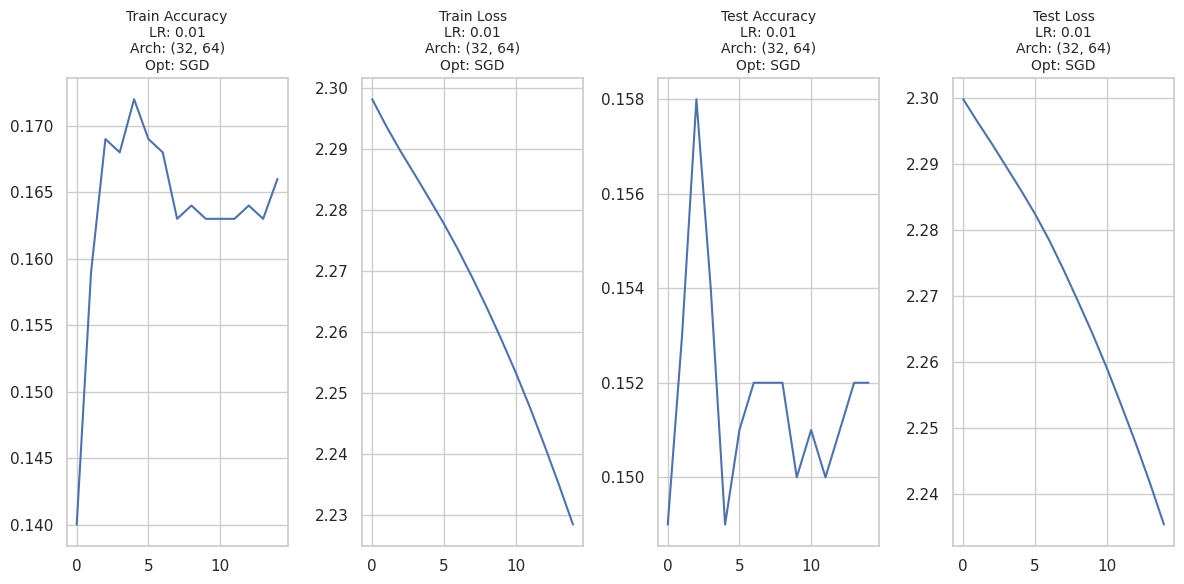

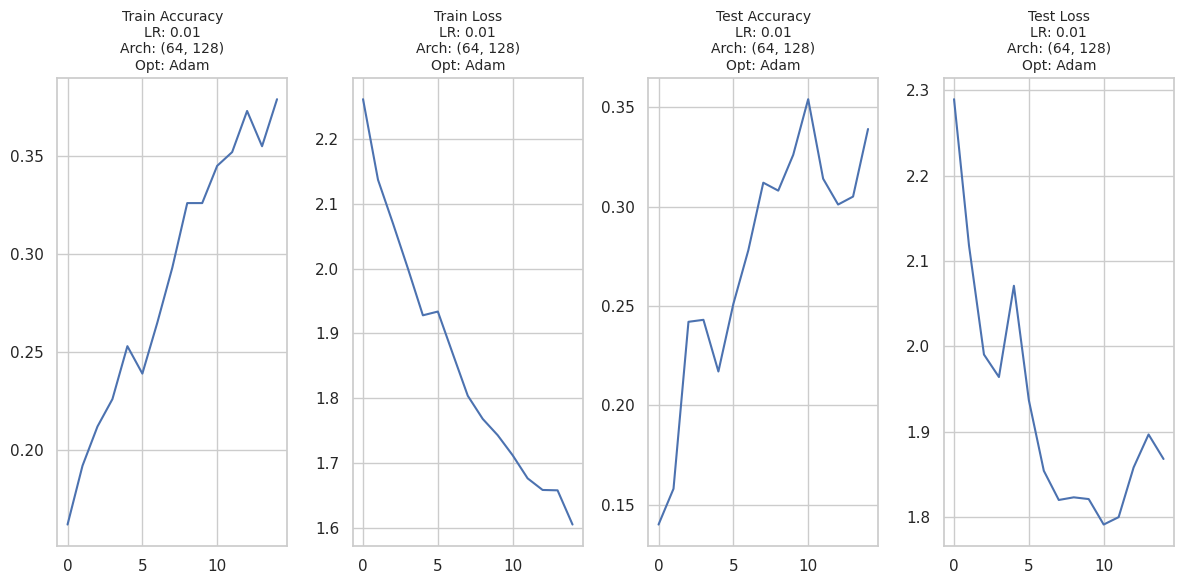

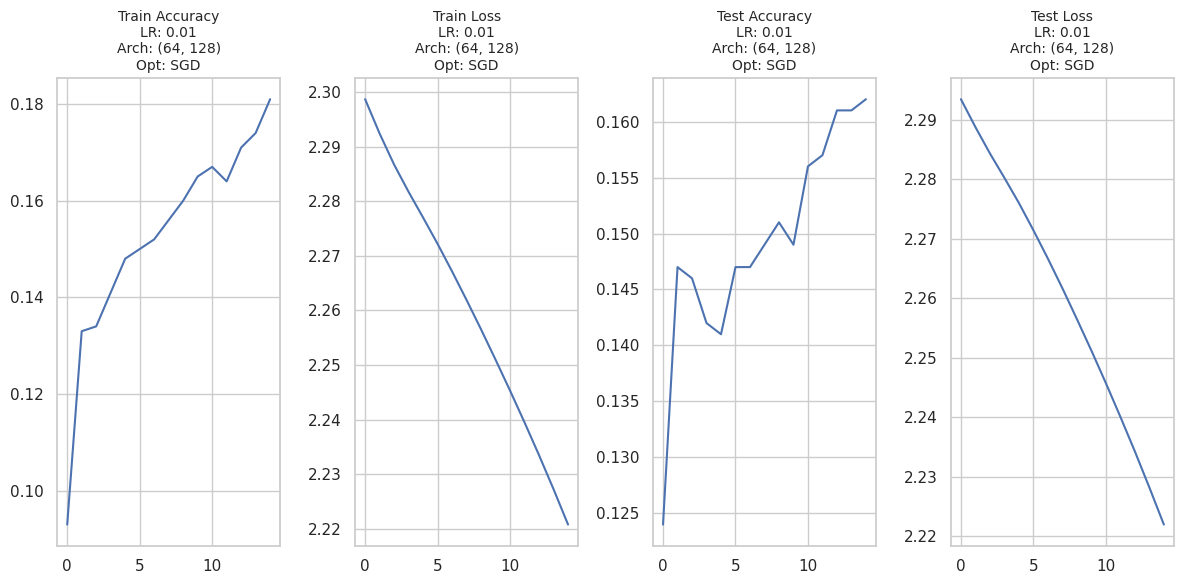

In [29]:
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Plot the results
for result in results:
    plt.figure(figsize=(12, 6))

    # Training Accuracy
    plt.subplot(1, 4, 1)
    plt.plot(result['train_accuracies'])
    plt.title(f'Train Accuracy\nLR: {result["learning_rate"]}\nArch: {result["architecture"]}\nOpt: {result["optimizer"]}', fontsize=10)

    # Training Loss
    plt.subplot(1, 4, 2)
    plt.plot(result['train_losses'])
    plt.title(f'Train Loss\nLR: {result["learning_rate"]}\nArch: {result["architecture"]}\nOpt: {result["optimizer"]}', fontsize=10)

    # Test Accuracy
    plt.subplot(1, 4, 3)
    plt.plot(result['test_accuracies'])
    plt.title(f'Test Accuracy\nLR: {result["learning_rate"]}\nArch: {result["architecture"]}\nOpt: {result["optimizer"]}', fontsize=10)

    # Test Loss
    plt.subplot(1, 4, 4)
    plt.plot(result['test_losses'])
    plt.title(f'Test Loss\nLR: {result["learning_rate"]}\nArch: {result["architecture"]}\nOpt: {result["optimizer"]}', fontsize=10)

    plt.tight_layout()
    plt.show()
